# Preprocessing and Feature Engineering

## Outline

<ol>
<li> Import and preprocess NFL Next Gen Stats (NGS) data. This dataset starts in 2016 and contains unique features that aren't available for prior years.</li>
<li> Import and preprocess NFLVerse's play-by-play data. This dataset contains most of the features for predicting a QB's pass touchdown performance. </li>
<li> Exploratory data analysis. I generate some additional features based on a number of observations in the data.</li>
</ol>

In [ ]:
# Imports.

# Data manipulation
import numpy as np
import pandas as pd
import polars as pl
import re

# Visualization
import seaborn as sns
import matplotlib.pyplot as plt

# Utilities
import os
os.chdir('<YOUR_ROOT_DIRECTORY>') # navigate to the root

from utils.nfl_utils import import_nflverse_data, compute_ema, plot_nfl_scatter

pl.Config(tbl_cols = 50, tbl_rows = 60, set_fmt_str_lengths = 150)

### Here is the NGS data. After a few cleaning steps we'll generate some features.

   - Baseline posterior mean for each QB's passing TDs using a basic Empirical Bayes approach
   - Backup QB dummy  

In [8]:
p_master = pl.scan_parquet('https://github.com/nflverse/nflverse-data/releases/download/nextgen_stats/ngs_passing.parquet')

p_master = (
    p_master
    # Remove season averages
    .filter((pl.col('week') > 0))
    .with_columns(
        # Recode the Rams abbreviation so it can be merged below
        pl.when(pl.col("team_abbr") == 'LAR').then(pl.lit('LA')).otherwise(pl.col('team_abbr')).alias('team_abbr'),

        # Remove team-game combinations with more than one QB
        pl.col('player_display_name').n_unique().over('season', 'week', 'team_abbr').alias('n_qbs')
    )
    .filter(pl.col('n_qbs') == 1)
    .with_columns(
        # Manually adjust the week number for last week of each season. It's incorrect.
        pl.col('week').max().over('season').alias('max_week')
    )
    .with_columns(
        pl.when((pl.col('week')) == (pl.col('max_week'))).then((pl.col('week')) - 1).otherwise(pl.col('week'))
    )
    .drop('max_week', 'n_qbs')
)

In [ ]:
# Compute each QB's posterior mean for pass touchdowns. Alpha hat and beta hat are the parameters for a Gamma prior. This basic empirical Bayes approach will serve as an anchor for predictions.
p_master = (
    p_master
    .with_columns(
        pl.col('pass_touchdowns').mean().over('season', 'week').alias('mean_pass_touchdowns'),
        pl.col('pass_touchdowns').var().over('season', 'week').alias('variance_pass_touchdowns')
    )
    .with_columns(
        # Alpha-hat
        pl.when(pl.col('variance_pass_touchdowns') > pl.col('mean_pass_touchdowns')).then((pl.col('mean_pass_touchdowns') ** 2) / (pl.col('variance_pass_touchdowns') - pl.col('mean_pass_touchdowns'))).otherwise(1).alias('alpha_hat'),
        
        # Beta-hat
        pl.when(pl.col('variance_pass_touchdowns') > pl.col('mean_pass_touchdowns')).then(pl.col('mean_pass_touchdowns') / (pl.col('variance_pass_touchdowns') - pl.col('mean_pass_touchdowns'))).otherwise(1).alias('beta_hat')
    )
    .sort('season', 'player_display_name', 'week')
    .with_columns(
        # Cumulative pass touchdowns by QB
        pl.col('pass_touchdowns').cum_sum().over('season', 'player_display_name').alias('cumulative_pass_touchdowns'),

        # Cumulative games played by QB
        pl.col('player_display_name').cum_count().over('season', 'player_display_name').alias('cumulative_qb_game_count')
    )
    .with_columns(
        # QB's posterior mean of touchdown passes
        ((pl.col('alpha_hat') + (pl.col('cumulative_pass_touchdowns'))) / (pl.col('beta_hat') + (pl.col('cumulative_qb_game_count')))).alias('pass_touchdowns_posterior_mean')
    )
    .select('season', 'week', 'player_display_name', 'team_abbr', 'attempts', 'completion_percentage', 'passer_rating', 'avg_air_yards_to_sticks', 'aggressiveness', 'avg_air_yards_differential', 'pass_touchdowns_posterior_mean', 'pass_touchdowns', 'cumulative_qb_game_count')
    .rename({'team_abbr': 'team'})
)

# Generate a backup QB dummy based on the number of complete games played. NFLVerse's depth charts data are too fluid week to week.
p_master = (
    p_master
    .sort('season', 'team', 'week')
    .with_columns(
        # Generate a cumulative game count for each team.
        pl.col('team').cum_count().over('season', 'team').alias('cumulative_game_count')
    )
    .with_columns(
        # Calculate each QB's share of all games played
        (pl.col('cumulative_qb_game_count') / pl.col('cumulative_game_count')).alias('qb_game_share')
    )
    .with_columns(
        # If the QB has played less than 50 percent of the games, classify him as a backup. This should capture almost all cases successfully.
        pl.when(pl.col('qb_game_share') < 0.5).then(1).otherwise(0).alias('backup_qb_dummy')
    )
    .drop('cumulative_game_count', 'qb_game_share')
)

### Now for the play-by-play data...

In [ ]:
# Gather data from play-by-play repo.
nflfastr_pbp_path = 'https://github.com/nflverse/nflverse-data/releases/download/pbp/'
pbp = import_nflverse_data(nflfastr_pbp_path, start_year = 2016, file_prefix = 'play_by_play')

# Obtain only the columns we need to engineer features.
pbp_select = pbp.select('season', 'week', 'game_id', 'game_date', 'posteam', 'defteam', 'home_team', 'away_team', 'play_type', 'qtr', 'down', 'drive', 'series_result', 'pass_attempt', 'rush_attempt', 'yards_gained', 'ydstogo', 'touchdown', 'sack', 'two_point_attempt', 'complete_pass', 'incomplete_pass', 'pass_length', 'pass_touchdown', 'passing_yards', 'yardline_100', 'posteam_score_post', 'passer_player_name', 'spread_line', 'total_line', 'div_game', 'weather', 'surface', 'roof')

# Drop rows that do not correspond to plays.
pbp_select = pbp_select.filter((pl.col('drive').is_not_null()) & (pl.col('play_type').is_not_null()) & (pl.col('posteam').is_not_null()) & (pl.col('defteam').is_not_null()))

# Recode two-point pass attempts classified as pass attempts to be 0. Then, remove two-point attempts.
pbp_select = (
    pbp_select
    .with_columns(
        pl.when((pl.col('two_point_attempt') == 1) & (pl.col('pass_attempt') == 1)).then(0).otherwise((pl.col('pass_attempt'))).alias('pass_attempt')
    )
    .filter(pl.col('two_point_attempt') == 0)
)

### From where on the field are pass touchdowns are most likely to occur?

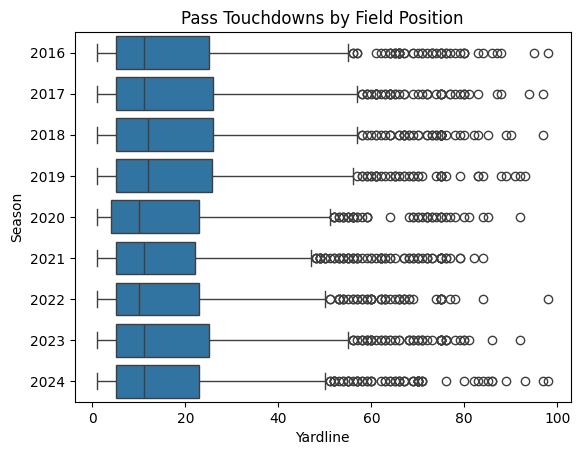

In [11]:
# Pass TD length distribution by season.
td_pass_field_position = (
    pbp_select
    .filter((pl.col('pass_touchdown') == 1))
    .select('season', 'week', 'posteam', 'yardline_100', 'yards_gained')
    .with_columns(
        pl.col('season').cast(pl.Utf8)
    )
    .collect()
)

sns.boxplot(data=td_pass_field_position, x='yardline_100', y='season')
plt.xlabel('Yardline')
plt.ylabel('Season')
plt.title('Pass Touchdowns by Field Position')
plt.show()

### Most come from within the redzone, so let's generate features capturing redzone passing performance.
   - Redzone pass play share
   - Redzone completion rate
   - Redzone pass touchdown rate

Note: We'll capture deep pass performance using <code>avg_air_yards_differential</code> from the NGS data.

In [12]:
# Generate redzone metrics.
pbp_redzone = (
    pbp_select
    .with_columns(
        pl.when(pl.col('play_type') == 'pass').then(1).otherwise(0).alias('pass_play'),
        pl.when(pl.col('play_type') == 'run').then(1).otherwise(0).alias('run_play')
    )
    .filter(pl.col('yardline_100') <= 20)
    .group_by(['season', 'week', 'posteam', 'defteam'])
    .agg(
        pl.col('pass_play').sum().alias('offense_redzone_pass_plays'),
        pl.col('run_play').sum().alias('offense_redzone_run_plays'),
        pl.col('pass_attempt').sum().alias('offense_redzone_pass_attempts'),
        pl.col('complete_pass').sum().alias('offense_redzone_complete_passes'),
        pl.col('pass_touchdown').sum().alias('offense_redzone_pass_touchdowns')
    )
    .with_columns(
        # Redzone pass play share
        ((pl.col('offense_redzone_pass_plays')) / ((pl.col('offense_redzone_pass_plays')) + ((pl.col('offense_redzone_run_plays'))))).alias('offense_redzone_pass_play_share'),
        
        # Redzone completion rate
        ((pl.col('offense_redzone_complete_passes')) / (pl.col('offense_redzone_pass_attempts'))).alias('offense_redzone_completion_rate'),

        # Redzone pass touchdown rate
        ((pl.col('offense_redzone_pass_touchdowns')) / (pl.col('offense_redzone_pass_attempts'))).alias('offense_redzone_pass_touchdown_rate')
    )
    .select('season', 'week', 'posteam', 'defteam', 'offense_redzone_pass_attempts', 'offense_redzone_pass_play_share', 'offense_redzone_completion_rate', 'offense_redzone_pass_touchdown_rate')
    .rename({'posteam': 'team'})
)

# Merge with the NGS data.
p_master_offense = (
    p_master
    .join(pbp_redzone, on=['season', 'week', 'team'], how='left')
)

p_master_offense = (
    p_master_offense
    .with_columns(
        # If redzone pass attempts is NULL, the offense never entered the endzone. Recode these as zero.
        pl.when(pl.col('offense_redzone_pass_attempts').is_null()).then(0).otherwise(pl.col('offense_redzone_pass_attempts')).alias('offense_redzone_pass_attempts')
    )
    .with_columns(
        # If redzone pass attempts equals 0, the team only ran run plays in the redzone. Recode other redzone pass metrics as zero.
        pl.when((pl.col('offense_redzone_pass_attempts')) == 0).then(0).otherwise(pl.col('offense_redzone_pass_play_share')).alias('offense_redzone_pass_play_share'),
        pl.when((pl.col('offense_redzone_pass_attempts')) == 0).then(0).otherwise(pl.col('offense_redzone_completion_rate')).alias('offense_redzone_completion_rate'),
        pl.when((pl.col('offense_redzone_pass_attempts')) == 0).then(0).otherwise(pl.col('offense_redzone_pass_touchdown_rate')).alias('offense_redzone_pass_touchdown_rate')
    )
)

### We want to capture defensive strength against redzone pass offense too. We'll do this by swapping <code>defteam</code> for <code>posteam</code>.

In [13]:
# We'll create the defensive features using this dataframe by renaming columns.
cols_to_rename = [col for col in p_master_offense.collect_schema().names() if 'offense' in col or 'def' in col]
p_master_defense = (
    p_master_offense
    .select('season', 'week', *cols_to_rename)
)

def_columns = []
for col in p_master_defense.collect_schema().names():
    new_col = col.replace('offense', 'defense')
    if 'defense' in new_col:
        new_col += '_allowed'
    def_columns.append(new_col)

p_master_defense = (
    p_master_defense
    .rename({old: new for old, new in zip(p_master_defense.collect_schema().names(), def_columns)})
)

# We'll apply a similar approach here. Recode redzone pass defense metrics when a team allowed no redzone pass attempts or prevented an offense from entering the redzone altogether.
p_master_defense = (
    p_master_defense
    .with_columns(
        pl.when(pl.col('defense_redzone_pass_attempts_allowed').is_null()).then(0).otherwise(pl.col('defense_redzone_pass_attempts_allowed')).alias('defense_redzone_pass_attempts_allowed')
    )
    .with_columns(
        pl.when((pl.col('defense_redzone_pass_attempts_allowed')) == 0).then(0).otherwise(pl.col('defense_redzone_pass_play_share_allowed')).alias('defense_redzone_pass_play_share_allowed'),
        pl.when((pl.col('defense_redzone_pass_attempts_allowed')) == 0).then(0).otherwise(pl.col('defense_redzone_completion_rate_allowed')).alias('defense_redzone_completion_rate_allowed'),
        pl.when((pl.col('defense_redzone_pass_attempts_allowed')) == 0).then(0).otherwise(pl.col('defense_redzone_pass_touchdown_rate_allowed')).alias('defense_redzone_pass_touchdown_rate_allowed')
    )
)

In [14]:
# Combine with the NGS dataframe.
p_master_combined = (
    p_master_offense
    .join(p_master_defense, how='left', on=['season', 'week', 'defteam'])
)

# Fill the NULL defteams. These resulted from aggregation above when no pass attempts were allowed in the redzone.
def_pos_match = (
    pbp_select
    .select('season', 'week', 'posteam', 'defteam')
    .rename({'posteam': 'team', 'defteam': 'defteam_no_null'})
    .unique()
)

p_master_combined = (
    p_master_combined
    .join(def_pos_match, on=['season', 'week', 'team'], how='left')
)

p_master_combined = (
    p_master_combined
    .with_columns(
        pl.when(pl.col('defteam').is_null()).then(pl.col('defteam_no_null')).otherwise(pl.col('defteam')).alias('defteam')
    )
    .drop('defteam_no_null')
)

# For a small number of games after the merge, all defensive features are NULL because no redzone pass attempts were allowed. In these cases, recode them as zero.
p_master_combined = (
    p_master_combined
    .with_columns(
        pl.when((pl.col('offense_redzone_pass_attempts') == 0)).then(0).otherwise(pl.col('defense_redzone_pass_attempts_allowed')).alias('defense_redzone_pass_attempts_allowed'),
        pl.when((pl.col('offense_redzone_pass_attempts') == 0)).then(0).otherwise(pl.col('defense_redzone_pass_play_share_allowed')).alias('defense_redzone_pass_play_share_allowed'),
        pl.when((pl.col('offense_redzone_pass_attempts') == 0)).then(0).otherwise(pl.col('defense_redzone_completion_rate_allowed')).alias('defense_redzone_completion_rate_allowed'),
        pl.when((pl.col('offense_redzone_pass_attempts') == 0)).then(0).otherwise(pl.col('defense_redzone_pass_touchdown_rate_allowed')).alias('defense_redzone_pass_touchdown_rate_allowed')
    )
)

### Let's grab a handful of other features to capture 'day-of' factors like weather and other game dynamics.
<ul>
    <li>Temperature, humidity, and wind speed</li>
    <li>Home and division game dummies</li>
    <li>Dummies for stadium type and field surface</li>
    <li>Implied point total for the offense</li>
</ul>

In [15]:
# Grab other variables mostly already available in the play-by-play data.
pbp_remainder = (
    pbp_select
    .select('season', 'week', 'posteam', 'home_team', 'spread_line', 'total_line', 'weather', 'surface', 'roof', 'div_game')
    .unique()
    .sort('season', 'week', 'posteam')
    .with_columns(
        # Generate variables for weather
        pl.col('weather').str.extract(r'Temp: (\d+)°').cast(pl.Int32).alias('temperature'),
        pl.col('weather').str.extract(r'Humidity: (\d+)%').cast(pl.Int32).alias('humidity'),
        pl.col('weather').str.extract(r'Wind: \w+ (\d+)').cast(pl.Int32).alias('wind_speed'),
        
        # Generate home dummy
        pl.when((pl.col('posteam') == (pl.col('home_team')))).then(1).otherwise(0).alias('home_dummy'),

    )
    .with_columns(
        # Calculate implied point total for each team
        pl.when((pl.col('posteam')) == (pl.col('home_team'))).then(((pl.col('total_line') + pl.col('spread_line')) / 2)).otherwise((pl.col('total_line') - pl.col('spread_line')) / 2).alias('implied_points'),

        # If roof is closed or dome, set wind speed to zero
        pl.when((pl.col('roof') == 'closed') | (pl.col('roof') == 'dome')).then(0).otherwise(pl.col('wind_speed')).alias('wind_speed'),

        # If temperature and humidity are NULL, it's because the game is played indoors. For these cases, impute the values as the mean for the season for those conditions. Wind speed is also NULL for some games played outdoors, probably because of a lack of data. We'll use a season-long mean for these cases as well.
        pl.col('temperature').mean().over('season', 'roof').alias('mean_temperature'),
        pl.col('humidity').mean().over('season', 'roof').alias('mean_humidity'),
        pl.col('wind_speed').mean().over('season', 'roof').alias('mean_wind_speed')
    )
    .with_columns(
        pl.when(pl.col('temperature').is_null()).then(pl.col('mean_temperature')).otherwise(pl.col('temperature')).alias('temperature'),
        pl.when(pl.col('humidity').is_null()).then(pl.col('mean_humidity')).otherwise(pl.col('humidity')).alias('humidity'),
        pl.when(pl.col('wind_speed').is_null()).then(pl.col('mean_wind_speed')).otherwise(pl.col('wind_speed')).alias('wind_speed')
    )
    .drop('home_team', 'weather', 'total_line', 'mean_temperature', 'mean_humidity', 'mean_wind_speed')
    .rename({'posteam': 'team'})
)

# Merge.
p_master_final = (
    p_master_combined
    .join(pbp_remainder, how='left', on=['season', 'week', 'team']) 
    .sort('season', 'player_display_name', 'week')
)

### Features should only contain information through the prior game.
<ul>
<li>We generate lagged exponentially-weighted moving averages (EWMA) for most features across a range of spans.</li>
<li>Select the version of the feature where the average absolute difference between the lagged EWMA and observed value is smallest.</li>
</ul>

In [16]:
# NGS data.
ngs_cols = ['attempts', 'completion_percentage', 'passer_rating', 'avg_air_yards_to_sticks', 'aggressiveness', 'avg_air_yards_differential', 'pass_touchdowns_posterior_mean']
ngs_group_cols = ['season', 'player_display_name']
spans = list(range(1, 13))
p_master_final_ngs_ema = compute_ema(p_master_final, ngs_cols, ngs_group_cols, spans)

# Other offensive data.
off_cols = [col for col in p_master_final.collect_schema().names() if 'offense' in col]
off_group_cols = ['season', 'team']

p_master_final_ngs_ema_off = (
    p_master_final_ngs_ema
    .sort('season', 'team', 'week')
)

p_master_final_ngs_ema_off_ema = compute_ema(p_master_final_ngs_ema_off, off_cols, off_group_cols, spans)

# Defensive data.
def_cols = [col for col in p_master_final.collect_schema().names() if 'defense' in col]
def_group_cols = ['season', 'defteam']

p_master_final_ngs_ema_off_ema_def = (
    p_master_final_ngs_ema_off_ema
    .sort('season', 'defteam', 'week')
)

p_master_final_ngs_ema_off_ema_def_ema = compute_ema(p_master_final_ngs_ema_off_ema_def, def_cols, def_group_cols, spans)

In [17]:
# Find the span for each feature where the average absolute difference between the EMA lag and observed value is smallest. These will be the versions that we bring into the dataset.
p_master_final_ngs_ema_off_ema_def_ema_pandas = p_master_final_ngs_ema_off_ema_def_ema.collect().to_pandas()

abs_diff_cols = [col for col in p_master_final_ngs_ema_off_ema_def_ema_pandas.columns if 'diff' in col]
p_master_final_ngs_ema_off_ema_def_ema_pandas_abs_diff = p_master_final_ngs_ema_off_ema_def_ema_pandas[abs_diff_cols]

col_means = {}
all_cols = ngs_cols + off_cols + def_cols

# Initialize empty dictionaries for each col.
for col in all_cols:
    col_means[col] = {}

# Compute means and assign them based on the matching condition.
for diff_col in p_master_final_ngs_ema_off_ema_def_ema_pandas_abs_diff.columns:
    mean = np.mean(np.abs(p_master_final_ngs_ema_off_ema_def_ema_pandas_abs_diff[diff_col]))
    for col in all_cols:
        if col in diff_col:
            col_means[col][diff_col] = mean

# Print the key-value pair with the smallest mean for each col.
for col, diff_dict in col_means.items():
    if diff_dict:
        smallest_key = min(diff_dict, key=diff_dict.get)  
        smallest_value = diff_dict[smallest_key]
        print(f'Feature: {col}, Smallest mean: {smallest_key} -> {smallest_value}')

Feature: attempts, Smallest mean: offense_redzone_pass_attempts_ema12_diff -> 2.5324076470072736
Feature: completion_percentage, Smallest mean: completion_percentage_ema12_diff -> 8.022730733309084
Feature: passer_rating, Smallest mean: passer_rating_ema12_diff -> 21.971516126297452
Feature: avg_air_yards_to_sticks, Smallest mean: avg_air_yards_to_sticks_ema12_diff -> 1.874043856080496
Feature: aggressiveness, Smallest mean: aggressiveness_ema12_diff -> 6.237866550851857
Feature: avg_air_yards_differential, Smallest mean: avg_air_yards_differential_ema12_diff -> 1.3286233680197983
Feature: pass_touchdowns_posterior_mean, Smallest mean: pass_touchdowns_posterior_mean_ema2_diff -> 0.18276270103387185
Feature: offense_redzone_pass_attempts, Smallest mean: offense_redzone_pass_attempts_ema12_diff -> 2.5324076470072736
Feature: offense_redzone_pass_play_share, Smallest mean: offense_redzone_pass_play_share_ema12_diff -> 0.19239999034569924
Feature: offense_redzone_completion_rate, Smallest 

### Select our features based on the output above.

In [20]:
# Select for our dataframe based on our analysis above.
cols_for_poisson = ['season', 'week', 'player_display_name', 'team', 'defteam', 'backup_qb_dummy', 'home_dummy', 'temperature', 'humidity', 'wind_speed', 'implied_points', 'pass_touchdowns', 'cumulative_qb_game_count'] + [col for col in p_master_final_ngs_ema_off_ema_def_ema.collect_schema().names() if ('ema12_lagged' in col or 'posterior_mean_ema2_lagged' in col) and ('posterior_mean_ema12_lagged' not in col)]
poisson_final = (
    p_master_final_ngs_ema_off_ema_def_ema
    .select(*cols_for_poisson).sort('season', 'week', 'team')
    .with_columns(
        pl.col('home_dummy').cast(pl.Int64).alias('home_dummy'),
        pl.col('backup_qb_dummy').cast(pl.Int64).alias('backup_qb_dummy')
    )
)

### Let's visualize this collection of features.

In [27]:
# Create a separate dataframe for visualization.
poisson_final_visualize = poisson_final.collect().to_pandas()

# Settings for plot grids.
features_to_plot = [col for col in poisson_final_visualize.columns if 'lagged' in col or (col == 'temperature' or col == 'humidity' or col == 'wind_speed' or col == 'implied_points')]
num_cols = 4
num_rows = (len(features_to_plot) + num_cols - 1) // num_cols

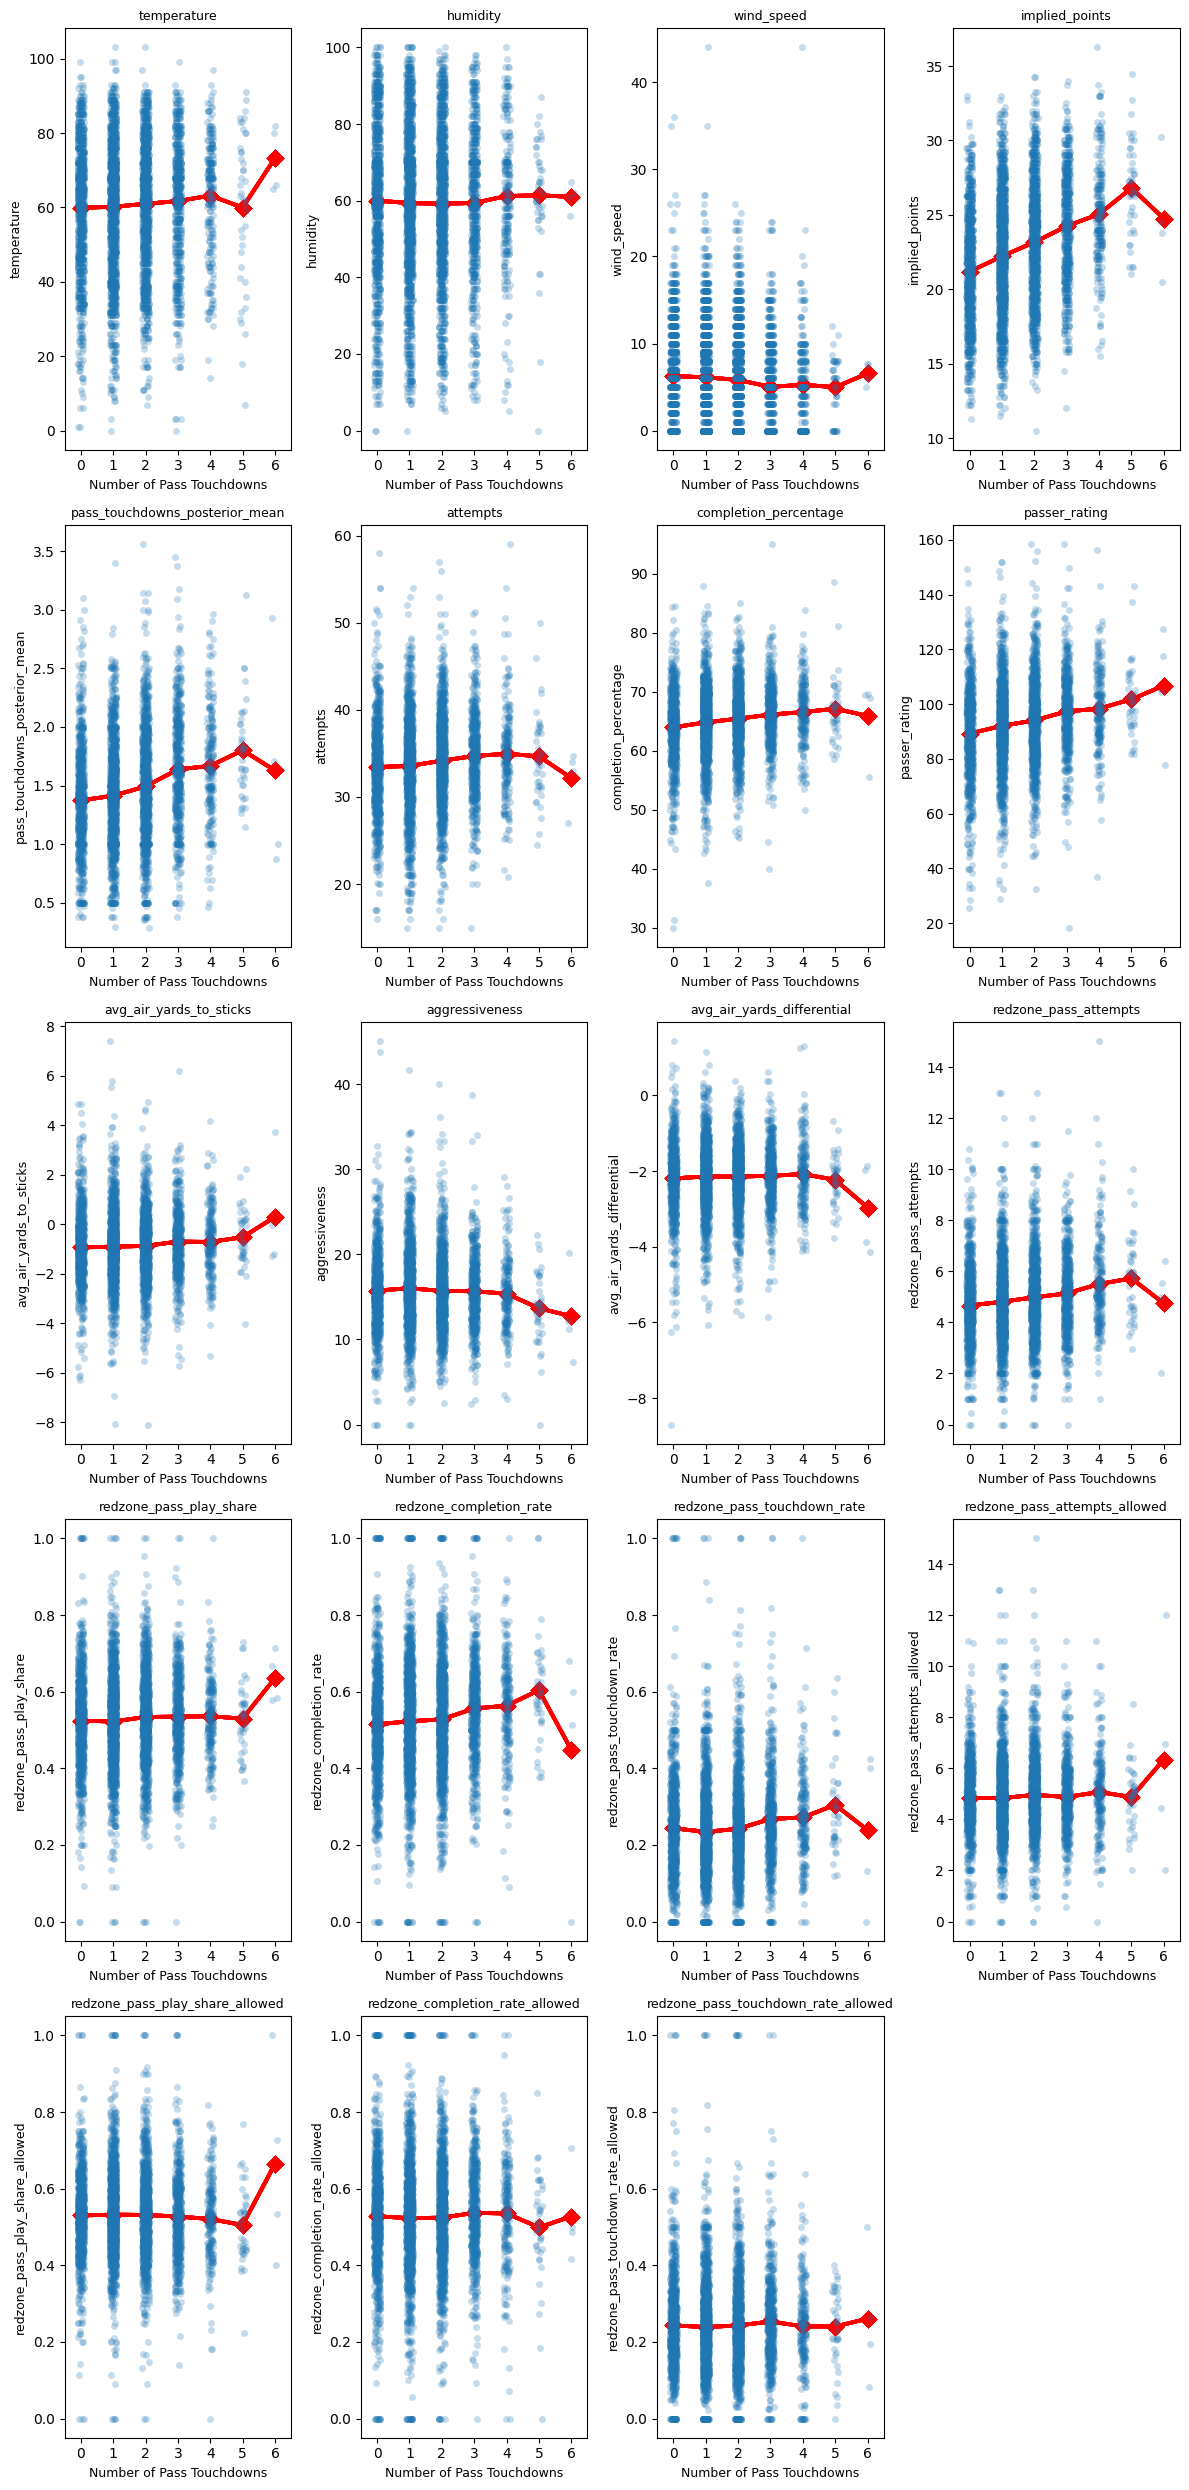

In [28]:
# Scatterplots of the feature set.
plot_nfl_scatter(poisson_final_visualize, features=features_to_plot, n_cols=num_cols, n_rows=num_rows, target_var='pass_touchdowns')

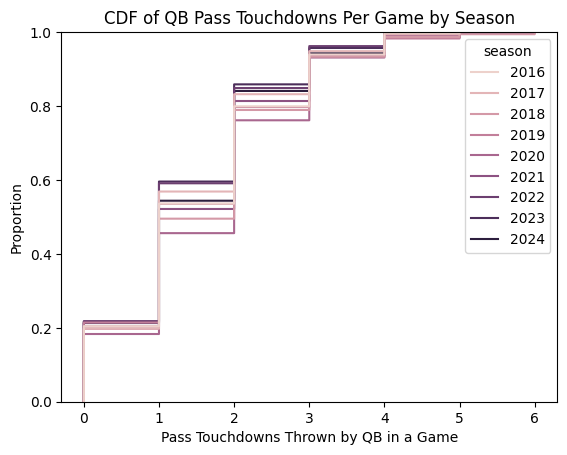

In [29]:
# CDFs of QB pass touchdown counts by season.
sns.ecdfplot(data=poisson_final_visualize, x="pass_touchdowns", hue='season')
plt.title('CDF of QB Pass Touchdowns Per Game by Season')
plt.xlabel('Pass Touchdowns Thrown by QB in a Game')
plt.show()

### We see a strong relationship between our target and several of our explanatory variables.
<ul>
    <li>Let's generate a few additional dummies based on the charts to capture specific cutoffs that appear to be negatively correlated with elite (3+) performances.</li>

In [30]:
# Let's generate some additional features based on the EDA.
poisson_final = (
    poisson_final
    .with_columns(
        # Pass touchdown performances of 3+ are less common with wind speeds greater than roughly 10 mph
        pl.when(pl.col('wind_speed') > 10).then(1).otherwise(0).alias('wind_speed_greater_10_dummy'),
        
        # Pass touchdown performances of 3+ are less common if the team has a low implied point total
        pl.when(pl.col('implied_points') < 21).then(1).otherwise(0).alias('low_implied_point_total_dummy'),
        
        # Pass touchdown performances of 3+ are less common if the QB is completing fewer than 40 percent of passes in the redzone
        pl.when(pl.col('offense_redzone_completion_rate_ema12_lagged') < 0.4).then(1).otherwise(0).alias('low_redzone_completion_percentage_dummy'),

        # Pass touchdown performances of 3+ are less common if the QB's rolling passer rating is below 80
        pl.when(pl.col('passer_rating_ema12_lagged') < 80).then(1).otherwise(0).alias('average_passer_rating_dummy'),

    )
    # Interactions
    .with_columns(
        pl.when((pl.col('wind_speed_greater_10_dummy') == 1) & (pl.col('low_implied_point_total_dummy') == 1)).then(1).otherwise(0).alias('high_wind_low_expected_point_total_dummy'),
        pl.when((pl.col('average_passer_rating_dummy') == 1) & (pl.col('low_implied_point_total_dummy') == 1)).then(1).otherwise(0).alias('avg_pr_low_expected_point_total_dummy'),
    )
)

### Drop the small number of remaining NULLs/NaNs, grab our features, and that should do it. Let's export and move on to cross validation!

In [31]:
# Drop the first game for each quarterback each season. We'll rely only on in-season data for predictions.
poisson_final = poisson_final.filter(pl.col('cumulative_qb_game_count') != 1).drop('cumulative_qb_game_count').collect()

# This leaves almost no remaining NULL and NaN issues. Let's double check to be sure, and then drop the remainder.
print('NULL Counts')
print(poisson_final.null_count())
print('')

float_cols = [col for col, dtype in poisson_final.schema.items() if dtype in [pl.Float32, pl.Float64]]
nan_counts = poisson_final.select([
    pl.col(col).is_nan().sum().alias(col) for col in float_cols
])

print('NaN Counts')
print(nan_counts)

poisson_final = poisson_final.drop_nulls().drop_nans()

NULL Counts
shape: (1, 33)
┌─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┐
│ sea ┆ wee ┆ pla ┆ tea ┆ def ┆ bac ┆ hom ┆ tem ┆ hum ┆ win ┆ imp ┆ pas ┆ pas ┆ att ┆ com ┆ pas ┆ avg ┆ agg ┆ avg ┆ off ┆ off ┆ off ┆ off ┆ def ┆ def ┆ def ┆ def ┆ win ┆ low ┆ low ┆ ave ┆ hig ┆ avg │
│ son ┆ k   ┆ yer ┆ m   ┆ tea ┆ kup ┆ e_d ┆ per ┆ idi ┆ d_s ┆ lie ┆ s_t ┆ s_t ┆ emp ┆ ple ┆ ser ┆ _ai ┆ res ┆ _ai ┆ ens ┆ ens ┆ ens ┆ ens ┆ ens ┆ ens ┆ ens ┆ ens ┆ d_s ┆ _im ┆ _re ┆ rag ┆ h_w ┆ _pr │
│ --- ┆ --- ┆ _di ┆ --- ┆ m   ┆ _qb ┆ umm ┆ atu ┆ ty  ┆ pee ┆ d_p ┆ ouc ┆ ouc ┆ ts_ ┆ tio ┆ _ra ┆ r_y ┆ siv ┆ r_y ┆ e_r ┆ e_r ┆ e_r ┆ e_r ┆ e_r ┆ e_r ┆ e_r ┆ e_r ┆ pee ┆ pli ┆ dzo ┆ e_p ┆ ind ┆ _lo │
│ u32 ┆ u32 ┆ spl ┆ u32 ┆ --- ┆ _du ┆ y   ┆ re  ┆ --- ┆ d   ┆ oin ┆ hdo ┆ hdo ┆ ema ┆ n_p ┆ tin ┆ ard ┆ ene ┆ ard ┆ edz ┆ edz ┆ edz ┆ edz ┆ edz ┆ edz ┆ edz ┆ edz ┆ d_g ┆ ed_

In [ ]:
# Select our columns and export to parquet.
poisson_final = poisson_final[[
    'season',
    'week',
    'player_display_name',
    'team',
    'defteam',
    'pass_touchdowns',
    'backup_qb_dummy',
    'wind_speed',
    'implied_points',
    'pass_touchdowns_posterior_mean_ema2_lagged',
    'completion_percentage_ema12_lagged',
    'passer_rating_ema12_lagged',
    'avg_air_yards_differential_ema12_lagged',
    'wind_speed_greater_10_dummy',
    'low_implied_point_total_dummy',
    'low_redzone_completion_percentage_dummy',
    'high_wind_low_expected_point_total_dummy',
]]

poisson_final.write_parquet('<YOUR_DATASETS_DIRECTORY>/qb.parquet')

poisson_final.tail()

season,week,player_display_name,team,defteam,pass_touchdowns,backup_qb_dummy,wind_speed,implied_points,pass_touchdowns_posterior_mean_ema2_lagged,completion_percentage_ema12_lagged,passer_rating_ema12_lagged,avg_air_yards_differential_ema12_lagged,wind_speed_greater_10_dummy,low_implied_point_total_dummy,low_redzone_completion_percentage_dummy,high_wind_low_expected_point_total_dummy
i32,i32,str,str,str,i32,i64,f64,f64,f64,f64,f64,f64,i32,i32,i32,i32
2024,21,"""Patrick Mahomes""","""KC""","""BUF""",1,0,8.0,25.5,1.575819,66.311246,97.013006,-2.400346,0,0,0,0
2024,21,"""Jalen Hurts""","""PHI""","""WAS""",1,0,11.0,26.25,1.284815,69.029408,106.664815,-1.921116,1,0,0,0
2024,21,"""Jayden Daniels""","""WAS""","""PHI""",1,0,11.0,20.25,1.656499,69.310295,105.61128,-1.648663,1,1,0,1
2024,22,"""Patrick Mahomes""","""KC""","""PHI""",3,0,0.0,25.0,1.542817,66.783766,99.415798,-2.264136,0,0,0,0
2024,22,"""Jalen Hurts""","""PHI""","""KC""",2,0,0.0,23.5,1.251801,69.425888,107.235654,-1.768894,0,0,0,0
